In [ ]:
import pandas as pd

df = pd.read_csv("Tox21.csv")
tox_cols = [
    'NR-AR','NR-AR-LBD','NR-AhR','NR-Aromatase','NR-ER','NR-ER-LBD',
    'NR-PPAR-gamma','SR-ARE','SR-ATAD5','SR-HSE','SR-MMP','SR-p53'
]

# Toxic in at least one assay
df_clean['toxic_any'] = (df_clean[tox_cols] == 1).any(axis=1)

df_toxic = df_clean[df_clean['toxic_any']].reset_index(drop=True)

print(df_toxic.shape)

(676, 15)


In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def mol_from_smiles(smiles):
    return Chem.MolFromSmiles(smiles)

mols = [mol_from_smiles(s) for s in df_toxic['smiles']]
mols = [m for m in mols if m is not None]

fps = np.array([
    AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)
    for m in mols
])

[14:20:57] Explicit valence for atom # 4 Al, 6, is greater than permitted
[14:20:57] Explicit valence for atom # 16 Al, 6, is greater than permitted
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WARNING: please use MorganGenerator
[14:20:57] DEPRECATION WA

In [ ]:
from rdkit import Chem
import pandas as pd


fg_smarts = {
    'Nitro': '[N+](=O)[O-]',
    'Aniline': '[NX3;H2][c]1[c][c][c][c][c]1',
    'Aromatic_amine': '[NX3;H2,H1][c]',
    'Halogenated_arene': '[c][F,Cl,Br,I]',
    'Michael_acceptor': '[C,c]=[C,c][C](=O)',
    'Poly_aromatic': 'c1cccc2c1cccc2'
}
fg_queries = {}
for name, smarts in fg_smarts.items():
    q = Chem.MolFromSmarts(smarts)
    if q:
        fg_queries[name] = q
    else:
        print(f"⚠️ Invalid SMARTS removed: {name}")



In [27]:
from rdkit.Chem import AllChem
import numpy as np

fps = np.array([
    AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=2048)
    for m in mols
])

[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerator
[14:40:47] DEPRECATION WARNING: please use MorganGenerat

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_3d = pca.fit_transform(fps)

print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.04444562 0.03654869 0.03288777]


In [31]:
import umap

umap_3d = umap.UMAP(
    n_components=3,
    n_neighbors=20,
    min_dist=0.1,
    random_state=42
)

X_3d = umap_3d.fit_transform(fps)

c:\Users\dy25544\.conda\envs\chem-ml-env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


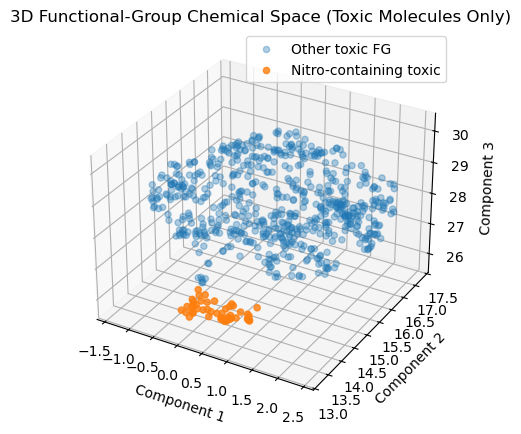

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

mask_nitro = fg_df['Nitro'] == 1
mask_other = fg_df['Nitro'] == 0

ax.scatter(
    X_3d[mask_other, 0],
    X_3d[mask_other, 1],
    X_3d[mask_other, 2],
    alpha=0.35,
    label='Other toxic FG'
)

ax.scatter(
    X_3d[mask_nitro, 0],
    X_3d[mask_nitro, 1],
    X_3d[mask_nitro, 2],
    alpha=0.8,
    label='Nitro-containing toxic'
)

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.title('3D Functional-Group Chemical Space (Toxic Molecules Only)')
plt.show()

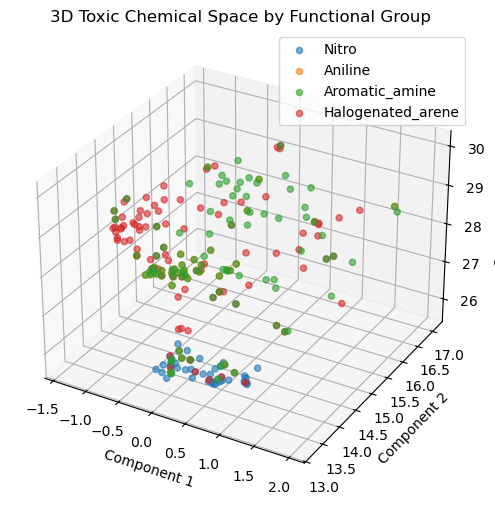

In [35]:
fg_colors = {
    'Nitro': 'red',
    'Aniline': 'blue',
    'Aromatic_amine': 'green',
    'Halogenated_arene': 'purple'
}

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for fg, color in fg_colors.items():
    mask = fg_df[fg] == 1
    ax.scatter(
        X_3d[mask,0],
        X_3d[mask,1],
        X_3d[mask,2],
        alpha=0.6,
        label=fg
    )

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.legend()
plt.title('3D Toxic Chemical Space by Functional Group')
plt.show()

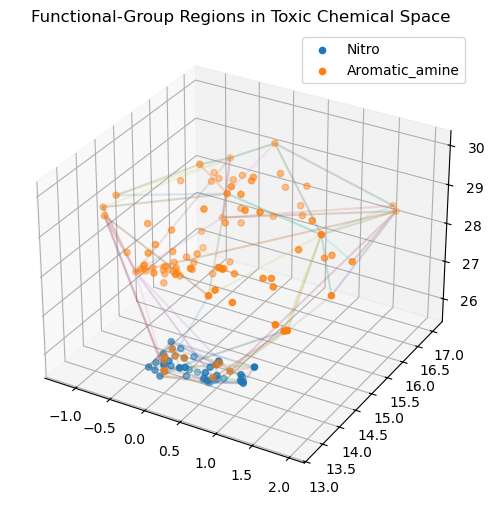

In [36]:
from scipy.spatial import ConvexHull

def plot_hull(points, ax, alpha=0.15):
    if len(points) < 4:
        return
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        ax.plot(points[simplex,0], points[simplex,1], points[simplex,2], alpha=alpha)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for fg in ['Nitro', 'Aromatic_amine']:
    mask = fg_df[fg] == 1
    ax.scatter(X_3d[mask,0], X_3d[mask,1], X_3d[mask,2], label=fg)
    plot_hull(X_3d[mask], ax)

ax.legend()
plt.title('Functional-Group Regions in Toxic Chemical Space')
plt.show()